# Bet Classifier - Determining how much to bet in Blackjack

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from utils.classifier_utils import *
from catboost import CatBoostRegressor

In [41]:
#set torch device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
print(device)

cuda:0


## Load the dataset

In [50]:
dataset_name =  'f_PPO_counting_4_decks_linear_lr_dataset.csv'
dataset = pd.read_csv('data/datasets/' + dataset_name,dtype=np.float32)
print(dataset.head())

   Ace   Two  Three  Four  Five   Six  Seven  Eight  Nine   Ten  Reward
0  2.0   2.0    0.0   1.0   0.0   2.0    3.0    0.0   2.0   4.0     1.0
1  9.0   8.0    2.0   8.0   5.0   5.0    7.0    5.0   5.0  16.0     1.0
2  9.0  12.0    8.0  11.0  14.0  11.0   11.0   12.0   8.0  43.0     1.0
3  1.0   2.0    8.0   4.0   4.0   3.0    5.0    4.0   5.0  16.0     1.0
4  3.0   5.0    1.0   2.0   5.0   3.0    1.0    2.0   2.0   5.0    -1.0


## Prepare dataloader for training

In [51]:
#split dataset into training and validation
batch_size = 1000
dataset_usage = 1.0 #percentage of dataset to use in total
split = 0.8 #percentage of dataset_usafe to use for training
train_dataset = BetsDataset(dataset.iloc[:int(len(dataset)*dataset_usage*split)])
val_dataset = BetsDataset(dataset.iloc[int(len(dataset)*dataset_usage*split):int(len(dataset)*dataset_usage)])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)



In [52]:
print('Training dataset size:', len(train_dataset))
print('Validation dataset size:', len(val_dataset))


Training dataset size: 8000000
Validation dataset size: 2000000


In [53]:
catboost_model = CatBoostRegressor(iterations=300, depth=4, learning_rate=0.1, loss_function='RMSE', task_type='GPU', devices='0:1', verbose=True)
catboost_model.fit(train_dataset.X, train_dataset.y, eval_set=(val_dataset.X, val_dataset.y), verbose=True)



0:	learn: 1.0277690	test: 1.0274159	best: 1.0274159 (0)	total: 60.6ms	remaining: 18.1s
1:	learn: 1.0277531	test: 1.0274009	best: 1.0274009 (1)	total: 120ms	remaining: 17.9s
2:	learn: 1.0277407	test: 1.0273876	best: 1.0273876 (2)	total: 172ms	remaining: 17s
3:	learn: 1.0277278	test: 1.0273754	best: 1.0273754 (3)	total: 225ms	remaining: 16.6s
4:	learn: 1.0277177	test: 1.0273648	best: 1.0273648 (4)	total: 274ms	remaining: 16.2s
5:	learn: 1.0277087	test: 1.0273544	best: 1.0273544 (5)	total: 326ms	remaining: 16s
6:	learn: 1.0276979	test: 1.0273451	best: 1.0273451 (6)	total: 377ms	remaining: 15.8s
7:	learn: 1.0276895	test: 1.0273376	best: 1.0273376 (7)	total: 428ms	remaining: 15.6s
8:	learn: 1.0276802	test: 1.0273308	best: 1.0273308 (8)	total: 480ms	remaining: 15.5s
9:	learn: 1.0276716	test: 1.0273221	best: 1.0273221 (9)	total: 532ms	remaining: 15.4s
10:	learn: 1.0276662	test: 1.0273167	best: 1.0273167 (10)	total: 583ms	remaining: 15.3s
11:	learn: 1.0276597	test: 1.0273100	best: 1.0273100 (1

In [54]:
predictions = catboost_model.predict(val_dataset.X)


In [55]:
#plot average reward for samples with prediction above threshold

thresholds = np.linspace(-0.1,1,110)
average_rewards = []
average_bet = []
counts = []
dynamic_average_rewards = []
odds = 20.0
for threshold in thresholds:
    mask = predictions > threshold
    p = val_dataset.y[mask]
    #find remaining samples
    not_p = val_dataset.y[~mask]
    if len(p) == 0:
        thresholds = thresholds[:np.where(thresholds == threshold)[0][0]]
        break
    count = len(p)
    counts.append(count)
    average_reward= np.mean(p)
    average_rewards.append(average_reward)
    not_p_average_reward = np.mean(not_p)
    #do a weighted average
    dynamic_reward = (average_reward*odds*count + not_p_average_reward*len(not_p))/(odds*count + len(not_p))
    dynamic_average_rewards.append(dynamic_reward)





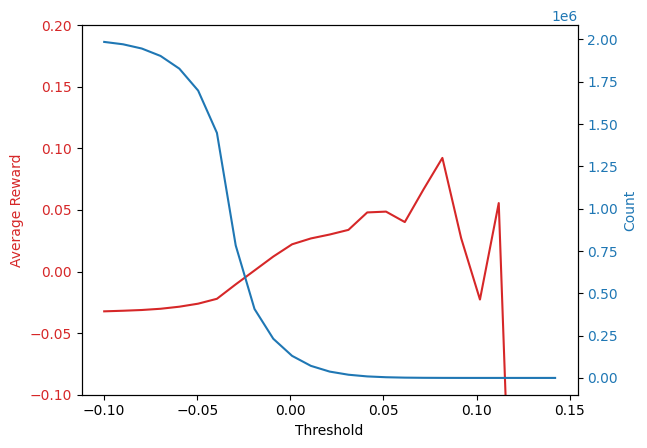

In [56]:

#plot average reward on one axis and count on the other
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('Threshold')
ax1.set_ylabel('Average Reward', color=color)
ax1.plot(thresholds, average_rewards, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim([-0.1,0.2])

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Count', color=color)
ax2.plot(thresholds, counts, color=color)
ax2.tick_params(axis='y', labelcolor=color)

Text(0.5, 1.0, 'Dynamic Average Reward vs Threshold')

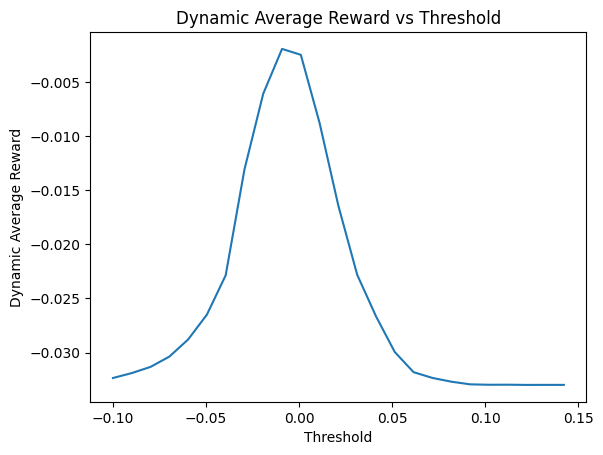

In [57]:
#plot the dynamic betting rewards for each threshold
plt.figure()
plt.plot(thresholds, dynamic_average_rewards)
plt.xlabel('Threshold')
plt.ylabel('Dynamic Average Reward')
plt.title('Dynamic Average Reward vs Threshold')


In [58]:
best_threshold = thresholds[np.argmax(dynamic_average_rewards)]
print(f"Best threshold: {thresholds[np.argmax(dynamic_average_rewards)]}") 
print(f"Best dynamic average reward: {np.max(dynamic_average_rewards)}")
print(f"number of samples with high bets: {counts[np.argmax(dynamic_average_rewards)]}")

Best threshold: -0.009174311926605505
Best dynamic average reward: -0.001965260668126021
number of samples with high bets: 231320


In [59]:
# save model
model_name = dataset_name.replace('dataset.csv', 'catboost_model.cbm')
catboost_model.save_model('data/classifiers/' + model_name)

In [60]:
print(best_threshold)

-0.009174311926605505


In [61]:
np.save('data/classifiers/' + model_name.replace('catboost_model.cbm', 'threshold.npy'), best_threshold)